In [100]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Vamos construir um dataset similar ao MNIST a partir das nossas placas de trânsito!

Temos 38 placas no total, com 64 distorções cada.

Deixaremos as últimas 8 placas exclusivamente como conjunto de teste, o que nos deixa com

$30 \times 64 \times 7 = 13,440$ dígitos de treinamento

$8 \times 64 \times 7 = 3,584$ dígitos de teste

In [101]:
# carregando nosso conjujto
mat = np.load('placas.npy')
mat.shape

(13000, 2432)

O nosso dataset já está ordenado, o que já ajuda bastante. As primeiras 64 imagens são as 64 variações da primeira placa, e assim por diante.

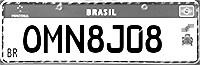

In [102]:
teste = mat[:, 63].reshape(65, 200)
imteste = Image.fromarray(teste)
imteste

O algoritmo a seguir nos auxiliará a montar o dataset de dígitos.

Ele funciona da seguinte forma:
1. Invertemos as cores da imagem, transformando-a em "branco no preto" ao invés de "preto no branco".
1. Removemos os "flancos" da imagem, para a focar apenas no texto.
1. Através de uma janela rolante com overlap, recortamos a imagem em 7 novas imagens,
a fim de, aproximadamente, isolar cada dígito.

In [103]:
def generate_crops(im):
    im = im.copy()
    im = Image.eval(im, lambda x: 255-x)
    im = im.crop((20, 20, im.width, im.height - 5))
    crops = np.zeros((7, 40 * 24))
    for i in range(7):
        start_x = i * (24 - 3)  # Overlap 3 pixels
        crop = im.crop((start_x, 0, start_x + 24, 40))
        crops[i] = np.array(crop).flatten()
    return crops

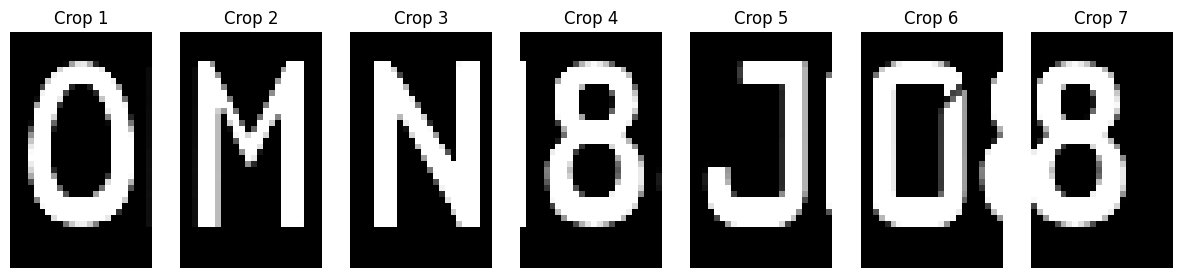

In [104]:
crops_teste = generate_crops(imteste)
fig, axes = plt.subplots(1, crops_teste.shape[0], figsize=(15, 5))
for i, ax in enumerate(axes):
    crop_image = crops_teste[i].reshape(40, 24)  # Reshape to the original dimensions
    ax.imshow(crop_image, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Crop {i+1}")

O algoritmo funciona! Vamos construir nosso dataset, então.

Ao contrário de seu antecessor, as imagens serão dispostas por linha, de forma a respeitar o padrão estabelecido pelo MNIST.

In [105]:
data_mat = np.zeros((38 * 64 * 7, 40 * 24))
print(f'Shape do dataset: {data_mat.shape}')

for i in tqdm(range(38 * 64)):
    imi = Image.fromarray(mat[:, i].reshape(65, 200))
    crops = generate_crops(imi)
    data_mat[i * 7: (i + 1) * 7] = crops

Shape do dataset: (17024, 960)


100%|██████████| 2432/2432 [00:00<00:00, 7040.61it/s]


E temos nosso dataset! Agora vamos randomizá-lo junto de seu gabarito.

In [106]:
f = open('placas.txt', 'r')
labels = f.readlines()
f.close()
labels = [l.strip() for l in labels]
print(labels[0:10])

# repete cada label 64 vezes
gabarito = [item for item in labels for _ in range(64)]
gabarito = ''.join(gabarito)
print(gabarito[0:7 * 2])

['OMN8J08', 'RYW1K02', 'MUO3S01', 'IDJ2V24', 'UTR5N48', 'ZCJ9G02', 'UAQ0A02', 'BLY4F77', 'GOB6N58', 'IPY6D84']
OMN8J08OMN8J08


In [107]:
# por convenção, embaralhamos as linhas do dataset
# temos que embaralhar o gabarito na mesma ordem
np.random.seed(42)
idx = np.random.permutation(data_mat.shape[0])
data_mat = data_mat[idx]
gabarito = [gabarito[i] for i in idx]

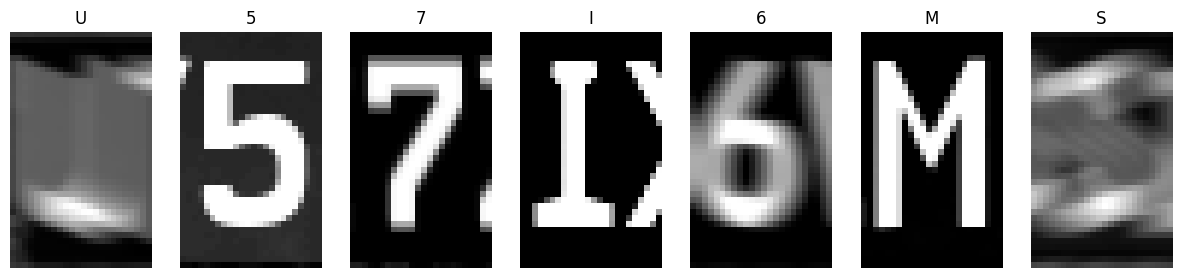

In [108]:
crops_teste_2 = data_mat[100:107]
gabarito_teste_2 = gabarito[100:107]
fig, axes = plt.subplots(1, crops_teste_2.shape[0], figsize=(15, 5))
for i, ax in enumerate(axes):
    crop_image = crops_teste_2[i].reshape(40, 24)  # Reshape to the original dimensions
    ax.imshow(crop_image, cmap="gray")
    ax.axis("off")
    ax.set_title(f"{gabarito_teste_2[i]}")

In [109]:
# salvamos as 30 * 64 * 7 como treino
# o restante como teste
np.save('treino.npy', data_mat[:30 * 64 * 7])
np.save('teste.npy', data_mat[30 * 64 * 7:])

# salvamos os gabaritos
with open('gabarito_treino.txt', 'w') as f:
    f.write(''.join(gabarito[:30 * 64 * 7]))

with open('gabarito_teste.txt', 'w') as f:
    f.write(''.join(gabarito[30 * 64 * 7:]))